In [70]:
# this is a modification to Stan's code to extract PI from MOT2. 
# changes: 
# 1. it finds the metadata file and reads it, uses information in the metadata to plot and annotate outputs 
# 2. it finds the last 30 seconds of arousal test (assuming there is only one arousal test episode) and computes
# the PI of that period
# 3. it plots arousal PI grouped by and colored by user defined categories (but see notes near the bottom).
# 4. future versions will also include: statitc test PI; arousal test PI for multiple episodes as in trace cond. 
# 5. future versions will be wrapped nicely in functions. 
# windows users should change the direction of the slashes i think
import shutil


import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import csv
import dabest
import seaborn as sns
%matplotlib inline

import os
currentPath = os.getcwd()
flagSwitchGenotype=False
##~~~~~~~~~~~~~~~~~ Windows users: Change the direction of slashes in the section below~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# the following line finds the sample data folder in the same folder as the code
# 2018-07-22-CS-Simultaneous-Green is an example of tests done with only CS files
# OK107Trace is an example of multiple sessions with 3 genotypes

datapath=currentPath+"/MOT2SampleData/"
# datapath=currentPath+"/MOT2SampleData/OK107Trace"

# # or user can define the path to data folder by uncommenting the following line
# datapath="/Users/xusy/Data/MOTSangyu/dump/2019-11-22_R58E02CasMS64Starved24hr"

datapath="/Users/xusy/Data/MOTSangyu/dump/2019-11-21_Gen0W1118HSDND/Tests"



experimentName=datapath.rsplit('/', 1)[-1]
if 1*("summary" in os.listdir(datapath))==0:
    os.mkdir(datapath + '/summary')
summaryFolderPath=datapath + '/summary/'
##~~~~~~~~~~~~~~~~~ Windows users: Change the direction of slashes in the section above~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print (datapath)
filenames = os.listdir(datapath)
filenames.sort()
#finds the countlogs here
countlogs= [s for s in filenames if "CountLog" in s]
#finds the metadata files here
metadatas = [s for s in filenames if "MetaData" in s]
PeriodToAnalyse=30
PIdfAllDay=[];
minStaticTestIndex=1
#proceses each countlog in alphabetical
for i in range(0, len(countlogs)):
    f = countlogs[i]
    m = 'MetaData'+ f[8:]



    df = pd.read_csv(datapath+'/'+f, error_bad_lines=False)
    dfMeta = pd.read_csv(datapath+'/'+m, error_bad_lines=False)
    shutil.copyfile(datapath+'/'+f, summaryFolderPath +'Countlog' + f[8:-4]+ '_anti' + dfMeta.loc[5, 'Odor'] + '_' + dfMeta.loc[5, 'Genotype']+ '.csv')
    #finds the bits in the countlogs that are arousal tests
    arousalTestIndex=[i for i, e in enumerate(df.ExperimentState) if "Arousal" in e]
    #picks out the last 30 data points (which at 1fps is 30 seconds) in future versions this should be made a function of framerate
    lastArousalTime = df.loc[arousalTestIndex[-1]].Seconds-PeriodToAnalyse
    absDiffArousalTime = np.absolute(df.loc[arousalTestIndex].Seconds-lastArousalTime)
    start30SecondArousalIdx = absDiffArousalTime.idxmin(skipna=True)
    last30secArousal = df.loc[start30SecondArousalIdx: arousalTestIndex[-1]]
    PIArousalAll=last30secArousal.filter(regex= "Ch"+str(5)+"_PI_r")

    SpeedArousalAll=last30secArousal.filter(regex= "Ch"+str(5)+"_Vpix/s")

    
    for chamber in range(6, 15):
        last30secArousalDF = last30secArousal.filter(regex= "Ch"+str(chamber)+"_PI_r")
        PIArousalAll["Ch"+str(chamber)+"_PI_r"] =last30secArousalDF.values  
        SpeedArousalAll=last30secArousal.filter(regex= "_Vpix/s").values
        


    PIallArousalAverage = PIArousalAll.mean(axis=0)
    PIallArousalAverage.values[np.flatnonzero(1*dfMeta.Odor[4:15]=='MCH')] = 0- PIallArousalAverage.values[np.flatnonzero(1*dfMeta.Odor[4:15]=='MCH')]

    GenotypeList=['Control Gal4', 'Control UAS', 'Test', 'CS']
    GenotypeNumber = 1*dfMeta.Genotype.str.contains('Gal4')+2*dfMeta.Genotype.str.contains('UAS')+4*dfMeta.Genotype.str.contains('CS')    
    PIresults={'Chambers':np.arange(5,15), 'Run':str(i+1), 'Odor':dfMeta.Odor[4:15],
               'Corrected Arousal PI':PIallArousalAverage.values.T,  
               'Genotype':dfMeta.Genotype[4:15], 'GenotypeNumber':GenotypeNumber[4:15]}

    #finds the bits in the countlogs that are arousal tests
    staticTestIndex=[i for i, e in enumerate(df.ExperimentState) if "Static" in e]
    if len(staticTestIndex) !=0:
        #picks out the last 30 data points (which at 1fps is 30 seconds) in future versions this should be made a function of framerate
        last30secStatic = df.loc[staticTestIndex[-PeriodToAnalyse:]]
        lastStaticTime = df.loc[staticTestIndex[-1]].Seconds-PeriodToAnalyse
        absDiffStaticTime = np.absolute(df.loc[staticTestIndex].Seconds-lastStaticTime)
        start30SecondStaticIdx = absDiffStaticTime.idxmin(skipna=True)
        last30secArousal = df.loc[start30SecondStaticIdx: staticTestIndex[-1]]
        PIStaticAll=last30secStatic.filter(regex= "Ch"+str(5)+"_PI_r")

        for chamber in range(6, 15):        
            last30secStaticDF = last30secStatic.filter(regex= "Ch"+str(chamber)+"_PI_r")
            PIStaticAll["Ch"+str(chamber)+"_PI_r"] =last30secStaticDF.values
        PIallStaticAverage = PIStaticAll.mean(axis=0)
        PIallStaticAverage.values[np.flatnonzero(1*dfMeta.Odor[4:15]=='MCH')] = 0- PIallStaticAverage.values[np.flatnonzero(1*dfMeta.Odor[4:15]=='MCH')]
        PIresults={'Chambers':np.arange(5,15), 'Run':str(i+1), 'Odor':dfMeta.Odor[4:15],
               'Corrected Arousal PI':PIallArousalAverage.values.T,  
               'Genotype':dfMeta.Genotype[4:15], 'GenotypeNumber':GenotypeNumber[4:15], 'Corrected Static PI':PIallStaticAverage.values.T}
    PIdf=pd.DataFrame(data=PIresults)
    PIdf.index=range(1, 11)
   


    GenotypeCorrected=[GenotypeList[PIdf.loc[i].GenotypeNumber-1] for i in range(1, 11)]
    PIdf=PIdf.assign(GenotypeCorrected = GenotypeCorrected)        
    PIdf=PIdf.drop(['GenotypeNumber'], axis=1)
    # the following lines save the average and raw PIs as .csv into a folder called 'summary' created in the original data folder
    PIdf.to_csv(summaryFolderPath + 'averagePI' + f[8:-4] + '.csv', sep=',', index=True, index_label = None)
    PIArousalAll.to_csv(summaryFolderPath + 'arousalRawPI'+ f[8:-4] + '.csv', sep=',', index=True)
    if len(staticTestIndex) !=0:
        PIStaticAll.to_csv(summaryFolderPath + 'staticRawPI'+ f[8:-4] + '.csv', sep=',', index=True)
    PIdfAllDay.append(PIdf)
    print(f)
    print(PIdf)
    print('Mean PI' + str(np.mean(PIallArousalAverage.values.T)))
    minStaticTestIndex = np.min([minStaticTestIndex, len(staticTestIndex)])
PIdfAllDay=pd.concat(PIdfAllDay)
PIdfAllDay.index=range(1, len(PIdfAllDay)+1)



/Users/xusy/Data/MOTSangyu/dump/2019-11-21_Gen0W1118HSDND/Tests


/Users/xusy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/xusy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CountLog_2019-11-21_13-50-57.csv
    Chambers Run Odor  Corrected Arousal PI Genotype  Corrected Static PI  \
1          5   1  MCH              0.724774    W1118             0.244133   
2          6   1  MCH              0.600000    W1118             0.906667   
3          7   1  MCH              0.714000    W1118             0.888900   
4          8   1  MCH              0.333000    W1118             0.277467   
5          9   1  MCH              0.714000    W1118             0.933333   
6         10   1  MCH              1.000000    W1118             0.933333   
7         11   1  MCH              1.000000    W1118             0.573633   
8         12   1  MCH              1.000000    W1118             0.877767   
9         13   1  MCH              1.000000    W1118             0.933333   
10        14   1  MCH              1.000000    W1118             0.233033   

   GenotypeCorrected  
1                 CS  
2                 CS  
3                 CS  
4                 CS  
5   

CountLog_2019-11-22_12-06-03.csv
    Chambers Run Odor  Corrected Arousal PI   Genotype  Corrected Static PI  \
1          5   8  OCT              0.667000  HSD Gen 0             0.228767   
2          6   8  OCT              1.000000  HSD Gen 0             0.256667   
3          7   8  OCT              0.903323  HSD Gen 0            -0.475500   
4          8   8  OCT              0.432065  HSD Gen 0            -0.842200   
5          9   8  OCT              0.406387  HSD Gen 0             0.097700   
6         10   8  OCT             -0.166645  HSD Gen 0            -0.128700   
7         11   8  OCT              0.559032  HSD Gen 0             0.000000   
8         12   8  OCT             -0.077387  HSD Gen 0             0.361000   
9         13   8  OCT              0.752935  HSD Gen 0            -0.046667   
10        14   8  OCT              0.572129  HSD Gen 0             0.013333   

   GenotypeCorrected  
1                 CS  
2                 CS  
3                 CS  
4    

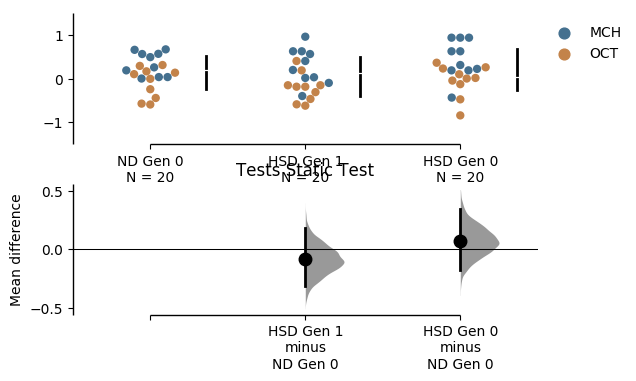

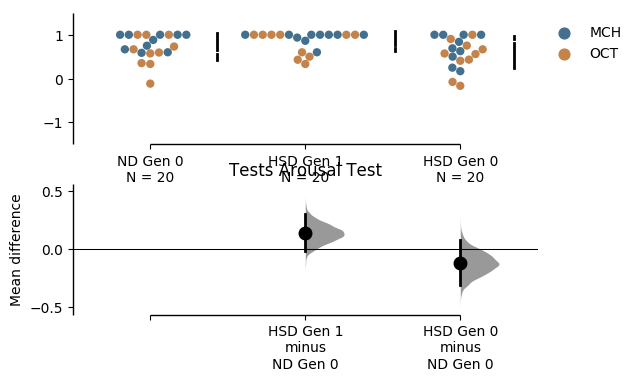

In [72]:
plt.figure
PIdfAllDay1=PIdfAllDay

PIdfAllDay1=PIdfAllDay.loc[PIdfAllDay.Genotype!='W1118']
# PIdfAllDay1=PIdfAllDay1.loc[PIdfAllDay1.Odor=='OCT']
PIdfAllDay1=PIdfAllDay1.reset_index()



uniqueGenotypeIdx=np.unique(PIdfAllDay1.Genotype, return_index=True)[1]
GenotypeLabels=[PIdfAllDay1.loc[j+1].Genotype for j in uniqueGenotypeIdx]



if flagSwitchGenotype:
    uniqueGenotypeIdx=np.unique(PIdfAllDay1.GenotypeCorrected, return_index=True)[1]
    GenotypeLabels=[PIdfAllDay1.loc[j+1].GenotypeCorrected for j in uniqueGenotypeIdx]
    genotypeToUse='GenotypeCorrected'
else:
    
    GenotypeLabels=np.sort(GenotypeLabels)[::-1]
    genotypeToUse='Genotype'

uniqueRunIdx=np.unique(PIdfAllDay1.Run, return_index=True)[1]
RunLabels=[PIdfAllDay1.loc[k+1].Run for k in uniqueRunIdx]
uniqueOdorIdx=np.unique(PIdfAllDay1.Odor, return_index=True)[1]
odorLabels=[PIdfAllDay1.loc[j+1].Odor for j in uniqueOdorIdx]




if minStaticTestIndex !=0:
    if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests        
        StaticB = dabest.load(PIdfAllDay1,
                           x=genotypeToUse, # the default for this test config is to group flies by genotype
                           y='Corrected Static PI',
                           idx=GenotypeLabels,
                           paired=False
                          )
    
        fStaticB = StaticB.mean_diff.plot(
                           color_col='Odor',# and color by odor
                           swarm_ylim =(-1.5,1.5),
                           fig_size=(6,4))


    else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies

        StaticB = dabest.load(PIdfAllDay1,
                           x='Odor', # the default for this test config is to group flies by genotype
                           y='Corrected Static PI',
                           idx=odorLabels,
                           paired=False
                          )
    
        fStaticB = StaticB.mean_diff.plot(
                           color_col='Odor',# and color by odor
                           swarm_ylim =(-1.5,1.5),
                           fig_size=(6,4))


    # print(b)
    plt.title(experimentName + ' Static Test')   
    plt.savefig(summaryFolderPath+ 'StaticContrast' + f[8:-4] + '.png', bbox_inches='tight', dpi = 300)

    
    
if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests
    ArousalB = dabest.load(PIdfAllDay1,
                           x=genotypeToUse, # the default for this test config is to group flies by genotype
                           y='Corrected Arousal PI',
                           idx=GenotypeLabels,
                           paired=False
                          )
    
    fAraousalB = ArousalB.mean_diff.plot(
                           color_col='Odor',# and color by odor
                           swarm_ylim =(-1.5,1.5),
                           fig_size=(6,4))
else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies
    ArousalB = dabest.load(PIdfAllDay1,
                           x='Run', # if just one type of flies, group by odor. This can also be "Run" 
                                      #which is the session/file in chronological sequence
                           y='Corrected Arousal PI',
                           idx=RunLabels, # this has to correspond to the value of x above. if x is 'Run', idx has to be 'RunLabels'
                           paired=False
                          )
    
    fArousalB = ArousalB.mean_diff.plot(
                            swarm_ylim =(-1.5,1.5),
                           fig_size=(6,4))
    
    
plt.title(experimentName + ' Arousal Test')   
# print(b)
# the following line saves the figure into a folder called 'summary' created in the original data folder
plt.savefig(summaryFolderPath+ 'ArousalContrast' + f[8:-4] + '.png', bbox_inches='tight', dpi = 300)
PIdfAllDay.to_csv(summaryFolderPath + 'PIdfAllDay'+ f[8:-4] + '.csv', sep=',', index=True)



In [64]:

uniqueGenotypeIdx=np.unique(PIdfAllDay1.Genotype, return_index=True)[1]
# GenotypeLabels=[PIdfAllDay1.loc[j+1].Genotype for j in uniqueGenotypeIdx]

PIdfAllDay1

,Chambers,Run,Odor,Corrected Arousal PI,Genotype,Corrected Static PI,GenotypeCorrected
11,5,2,OCT,0.911903,W1118,0.250967,CS
12,6,2,OCT,0.845290,W1118,0.000000,CS
13,7,2,OCT,1.000000,W1118,0.306367,CS
14,8,2,OCT,0.418714,W1118,0.150276,CS
15,9,2,OCT,1.000000,W1118,0.666400,CS
16,10,2,OCT,0.783000,W1118,0.439967,CS
17,11,2,OCT,1.000000,W1118,0.310800,CS
18,12,2,OCT,1.000000,W1118,0.344133,CS
19,13,2,OCT,0.667000,W1118,-0.933333,CS
20,14,2,OCT,0.989258,W1118,0.000000,CS


In [4]:
FullPI = pd.read_csv(datapath+'/Summary/FullPI.csv', error_bad_lines=False)
FullPI

FileNotFoundError: [Errno 2] File b'/Users/xusy/Data/MOTSangyu/dump/2019-11-21_Gen0W1118HSDND/Tests/Summary/FullPI.csv' does not exist: b'/Users/xusy/Data/MOTSangyu/dump/2019-11-21_Gen0W1118HSDND/Tests/Summary/FullPI.csv'

In [3]:
Static = dabest.load(FullPI,
                           x='Status', # the default for this test config is to group flies by genotype
                           y='Full Static PI',
                           idx=['Sibling', 'Offspring'],
                           paired=False
                          )
    
fStatic = Static.mean_diff.plot(
                           color_col='Genotype',# and color by odor
                           swarm_ylim =(-1.5,1.5),
                           fig_size=(4,6))

Arousal = dabest.load(FullPI,
                           x='Status', # the default for this test config is to group flies by genotype
                           y='Full Arousal PI',
                           idx=['Sibling', 'Offspring'],
                           paired=False
                          )
    
fArousal = Arousal.mean_diff.plot(
                           color_col='Genotype',# and color by odor
                           swarm_ylim =(-1.5,1.5),
                           fig_size=(4,6))




NameError: name 'FullPI' is not defined

In [59]:
# uniqueGenotypeIdx=np.unique(PIdfAllDay1.Genotype, return_index=True)[1]
# GenotypeLabels=[PIdfAllDay1.loc[j+1].Genotype for j in uniqueGenotypeIdx]



,index,Chambers,Run,Odor,Corrected Arousal PI,Genotype,Corrected Static PI,GenotypeCorrected
0,11,5,2,OCT,0.911903,W1118,0.250967,CS
1,12,6,2,OCT,0.845290,W1118,0.000000,CS
2,13,7,2,OCT,1.000000,W1118,0.306367,CS
3,14,8,2,OCT,0.418714,W1118,0.150276,CS
4,15,9,2,OCT,1.000000,W1118,0.666400,CS
5,16,10,2,OCT,0.783000,W1118,0.439967,CS
6,17,11,2,OCT,1.000000,W1118,0.310800,CS
7,18,12,2,OCT,1.000000,W1118,0.344133,CS
8,19,13,2,OCT,0.667000,W1118,-0.933333,CS
9,20,14,2,OCT,0.989258,W1118,0.000000,CS


In [35]:
uniqueGenotypeIdx

array([ 0, 20, 10])

In [52]:
uniqueGenotypeIdx=np.unique(PIdfAllDay1.Genotype, return_index=True)[1]

In [53]:
uniqueGenotypeIdx

array([30, 10, 20,  0])